# Goal
## Train models using any methods you have learned so far to achieve best accuracy on the testing data. You can plot the train.csv and try to ensemble models that performs well on different competitors

## Read this note carefully
1. Submit to iLMS with your code file Lab08_{student_id}.ipynb. The notebook should contain
2. Your code and accuracy by all the models you have tried, which will at least include voting, bagging, and boosting models
3. Use Gridsearch to fine-tune your results. In particular, for base learner of adaboost, we hope you can try decision stump (decision tree with depth 1) and decision tree with higher depths
4. Try to evaluate and summarize the results
# Deadline: 2020-10-20(Tue) 23:59
## Please make sure that we can rerun your code
## Please keep all the models you have tried in your ipynb
### The following is example code to load and plot the training data

In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.7.3
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.17.1
import numpy as np

# pandas  0.25.1
import pandas as pd

# scikit-learn  0.21.3
from sklearn import datasets
load_iris = datasets.load_iris
make_moons = datasets.make_moons
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier

# matplotlib  3.1.1
import matplotlib.pyplot as plt

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

# preprocess data

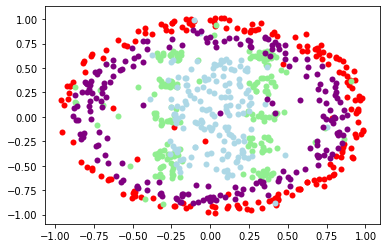

In [2]:
file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark':2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X = np.vstack((X, np.array(row[0:2])))
  y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

# Voting

(590, 2)
(148, 2)


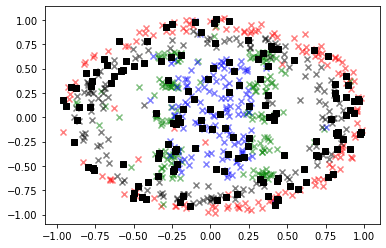

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
print(X_train.shape)
print(X_test.shape)

plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
            label='Class 0', c='r', marker='x', alpha=0.5)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
            label='Class 1', c='g', marker='x', alpha=0.5)
plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1], 
            label='Class 2', c='b', marker='x', alpha=0.5)
plt.scatter(X_train[y_train == 3, 0], X_train[y_train == 3, 1], 
            label='Class 3', c='0', marker='x', alpha=0.5)
plt.scatter(X_test[:, 0], X_test[:, 1], label='Class 1', c='0', marker='s')
plt.show()

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C = 10, random_state = 0, solver = "liblinear")]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth = None, random_state = 0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors = 5)]])

## cross_val_score

In [4]:
clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10)
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
LogisticRegression: 0.317 (+/- 0.056)
DecisionTree: 0.744 (+/- 0.039)
KNN: 0.814 (+/- 0.049)


In [5]:
print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)], 
                           voting='soft', weights=[a,b,c])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10)
    print('%s: %.3f (+/- %.3f)' % ((a,b,c), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]
(0, 1, 2): 0.800 (+/- 0.043)
(0, 2, 1): 0.744 (+/- 0.039)
(1, 0, 2): 0.812 (+/- 0.049)
(1, 2, 0): 0.744 (+/- 0.039)
(2, 0, 1): 0.786 (+/- 0.053)
(2, 1, 0): 0.744 (+/- 0.039)

Best (1, 0, 2): 0.812


In [6]:
#test
print('KNN test')
clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)], 
                           voting='soft', weights=[0,1,2])
clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

knn_train = accuracy_score(y_train, y_train_pred)
knn_test = accuracy_score(y_test, y_test_pred)
print('accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))

KNN test


NameError: name 'tree_train' is not defined

In [ ]:
print('KNN different hyperparameter')

best_k, best_score = -1, -1
clfs = {}

for k in [1, 5, 10, 15, 50]: # experiment different hyperparameter
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=k)]])
    pipe.fit(X_train, y_train)
    # K-Fold CV
    scores = cross_val_score(pipe, X_train, y_train, cv=5)
    print('[%d-NN]\nValidation accuracy: %.3f %s' % (k, scores.mean(), scores))
    if scores.mean() > best_score:
        best_k, best_score = k, scores.mean()
    clfs[k] = pipe

# Bagging

In [7]:
tree = Pipeline([['clf', DecisionTreeClassifier(max_depth = None, random_state = 0)]])
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

# single DecisionTree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))
# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] accuracy-train = %.3f, accuracy-test = %.3f' % (bag_train, bag_test))

[DecisionTree] accuracy-train = 1.000, accuracy-test = 0.777
[Bagging] accuracy-train = 0.997, accuracy-test = 0.838


In [8]:
knn = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=5)]])
bag = BaggingClassifier(base_estimator=knn, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

# single DecisionTree
tree = knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

knn_train = accuracy_score(y_train, y_train_pred)
knn_test = accuracy_score(y_test, y_test_pred)
print('[knn] accuracy-train = %.3f, accuracy-test = %.3f' % (knn_train, knn_test))
# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] accuracy-train = %.3f, accuracy-test = %.3f' % (bag_train, bag_test))

[knn] accuracy-train = 0.886, accuracy-test = 0.811
[Bagging] accuracy-train = 0.869, accuracy-test = 0.824


# Boosting

# SVM

In [9]:
svr_rbf = Pipeline([['sc', StandardScaler()], ['rbf', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)]])
svr_lin = Pipeline([['sc', StandardScaler()], ['linear', SVR(kernel='linear', C=100, gamma='auto')]])
svr_poly = Pipeline([['sc', StandardScaler()], ['poly', SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,coef0=1)]])

clf_labels = ['svr_rbf', 'svr_linear', 'svr_poly']
print('[Individual]')
for pipe, label in zip([svr_rbf, svr_lin, svr_poly], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10)
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
svr_rbf: -0.013 (+/- 0.216)
svr_linear: -0.222 (+/- 0.232)
svr_poly: -0.070 (+/- 0.209)


# Nested CV

In [10]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)): 
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    best_k, best_score = -1, -1
    clfs = {}
    # hyperparameter tuning 
    for k in [1, 15, 50]:
        inner_scores = []
        # inner folds
        for itrain_idx, val_idx in inner_cv.split(X_train, y_train):
            X_itrain, X_val = X_train[itrain_idx], X_train[val_idx]
            y_itrain, y_val = y_train[itrain_idx], y_train[val_idx]
            
            pipe = Pipeline([['sc', StandardScaler()],
                             ['clf', KNeighborsClassifier(n_neighbors=k)]])
            pipe.fit(X_itrain, y_itrain)
            
            y_pred = pipe.predict(X_val)
            inner_scores.append(accuracy_score(y_val, y_pred))
        score_mean = np.mean(inner_scores)
        if best_score < score_mean:
            best_k, best_score = k, score_mean
        clfs[k] = pipe
        
    # evaluate performance on test fold
    best_clf = clfs[best_k]
    best_clf.fit(X_train, y_train)    
    y_pred = best_clf.predict(X_test)
    outer_scores.append(accuracy_score(y_test, y_pred))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], best_k))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.82 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.81 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.78 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.77 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.82 (n_neighbors=1 selected by inner 10-fold CV)

Test accuracy: 0.80 (5x10 nested CV)


# GridSearch

In [11]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier()]])
    # hyperparameter tuning by grid search CV
    param_grid = {'clf__n_neighbors':[1, 15, 50]}
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__n_neighbors']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.82 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.81 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.78 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.77 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.82 (n_neighbors=1 selected by inner 10-fold CV)

Test accuracy: 0.80 (5x10 nested CV)


# decision tree with GridSearch

In [12]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipe = Pipeline([['sc', StandardScaler()], ['clf', DecisionTreeClassifier(max_depth = None, random_state = 0)]])
    # hyperparameter tuning by grid search CV
    depths = np.arange(1, 21)
    param_grid = [{'clf__max_depth':depths}]
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (max_depth=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__max_depth']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.80 (max_depth=7 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.80 (max_depth=7 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.78 (max_depth=6 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.83 (max_depth=7 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.80 (max_depth=7 selected by inner 10-fold CV)

Test accuracy: 0.80 (5x10 nested CV)


# adaboost + GridSearch + decision stump

In [13]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [5, 50, 100, 500]
             }
    tree = DecisionTreeClassifier(max_depth = 1, random_state = 0)
    ada = AdaBoostClassifier(base_estimator = tree)
    gs = GridSearchCV(estimator=ada, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (estimators=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['n_estimators']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.53 (estimators=100 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.60 (estimators=500 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.61 (estimators=100 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.61 (estimators=500 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.59 (estimators=500 selected by inner 10-fold CV)

Test accuracy: 0.59 (5x10 nested CV)


# adaboost + GridSearch + decision tree max_depth = 50

In [14]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [5, 50, 100, 500]
             }
    tree = DecisionTreeClassifier(max_depth = 7, random_state = 0)
    ada = AdaBoostClassifier(base_estimator = tree)
    gs = GridSearchCV(estimator=ada, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (estimators=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['n_estimators']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.81 (estimators=100 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.85 (estimators=500 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.80 (estimators=500 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.83 (estimators=500 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.79 (estimators=50 selected by inner 10-fold CV)

Test accuracy: 0.82 (5x10 nested CV)


# 大部分情況下，不管是voting、bagging、boosting都可以讓準確率提高，在所有嘗試中，最高準確的情況是DecisionTree + bagging，準確率有0.838
# DecisionTree+GridSearch可達到準確率0.80、max depth = 7
# Decision stump + adaboost + GridSearch準確率可達到0.80
# Decisiontree(max depth = 7) + adaboost + GridSearch準確率可達到0.82